# Deep Neural Network

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

In [2]:
data_path = 'EN_Tianchi_power_v2.csv'

power = pd.read_csv(data_path)

In [3]:
power.head()

,user_id,power_consumption,year,month,day,weekday,holiday,season,workday,climate,windspeed,temp
0,1,1135,1,1,1,4,1,1,0,1,1,2.0
1,1,570,1,1,2,5,1,1,0,1,1,6.5
2,1,3418,1,1,3,6,1,1,0,1,1,9.5
3,1,3968,1,1,4,0,0,1,1,1,2,9.5
4,1,3986,1,1,5,1,0,1,1,2,3,6.0


# Choose user_id = 1 to predict

In [4]:
power = power.loc[(power.user_id == 1), :]

In [5]:
power.head()

,user_id,power_consumption,year,month,day,weekday,holiday,season,workday,climate,windspeed,temp
0,1,1135,1,1,1,4,1,1,0,1,1,2.0
1,1,570,1,1,2,5,1,1,0,1,1,6.5
2,1,3418,1,1,3,6,1,1,0,1,1,9.5
3,1,3968,1,1,4,0,0,1,1,1,2,9.5
4,1,3986,1,1,5,1,0,1,1,2,3,6.0


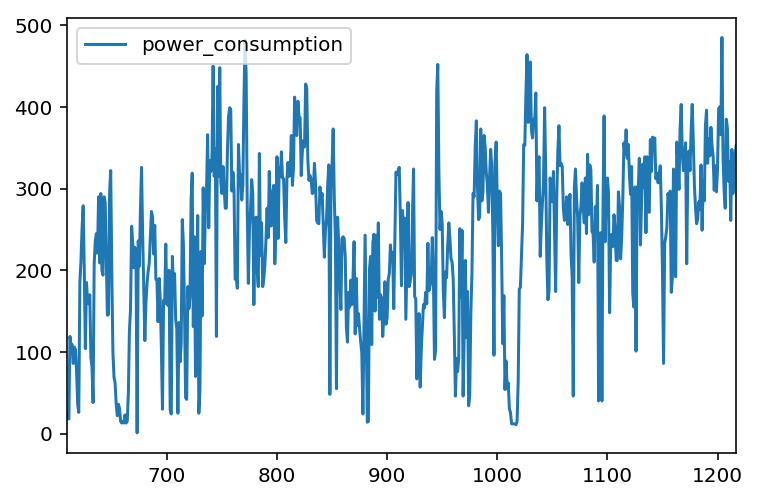

In [6]:
power.plot(y='power_consumption')

### Dummy variables

In [7]:
dummy_fields = ['year', 'month', 'day', 'weekday', 'season', 'climate', 'windspeed']

for each in dummy_fields:
    dummies = pd.get_dummies(power[each], prefix=each, drop_first=False)
    power = pd.concat([power, dummies], axis=1)

fields_to_drop = ['year', 'month', 'day', 'weekday', 'season', 'climate', 'windspeed', 'user_id']
data = power.drop(fields_to_drop, axis=1)
data.head()

,power_consumption,holiday,workday,temp,year_0,year_1,month_1,month_2,month_3,month_4,...,season_1,season_2,season_3,season_4,climate_1,climate_2,climate_3,windspeed_1,windspeed_2,windspeed_3
609,24,1,0,2.0,0,1,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0
610,22,1,0,6.5,0,1,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0
611,18,1,0,9.5,0,1,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0
612,119,0,1,9.5,0,1,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
613,108,0,1,6.0,0,1,1,0,0,0,...,1,0,0,0,0,1,0,0,0,1


### Scaling target variables

In [8]:
quant_features = ['power_consumption', 'temp']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    max_, min_ = data[each].max(), data[each].min()
    scaled_features[each] = [max_, min_]
    data.loc[:, each] = (data[each] - min_)/(max_ - min_)

### Splitting the data into training, testing, and validation sets

In [9]:
# Separate the data into features and targets
target_fields = ['power_consumption']
features, targets = data.drop(target_fields, axis=1), data[target_fields]

from sklearn.model_selection import train_test_split
train_features, val_features, train_targets, val_targets = train_test_split(features, targets, test_size=0.1, random_state=42)

In [10]:
train_features.head()

,holiday,workday,temp,year_0,year_1,month_1,month_2,month_3,month_4,month_5,...,season_1,season_2,season_3,season_4,climate_1,climate_2,climate_3,windspeed_1,windspeed_2,windspeed_3
881,0,1,0.717647,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
718,0,1,0.517647,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
921,0,1,0.435294,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
937,0,1,0.247059,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
1024,0,0,0.305882,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0


In [11]:
len(train_features)

548

In [12]:
len(val_features)

61

### Build the network

In [13]:
from distutils.version import LooseVersion
import tensorflow as tf
import warnings

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


C:\ProgramData\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\__main__.py:11: UserWarning: No GPU found. Please use a GPU to train your neural network.


In [14]:
def leaky_relu(x, alpha=0.2, name='leaky_relu'):
    return tf.maximum(x, alpha * x, name=name)

In [15]:
input_ = tf.placeholder(tf.float32, [None, 65], name = "inputs")
label_ = tf.placeholder(tf.float32, [None, 1], name = "outputs")
keep_prob = tf.placeholder(tf.float32) # probability to keep units
lr = tf.placeholder(tf.float32) # learning rate

layer1 = tf.layers.dense(input_, 128, activation = leaky_relu, kernel_initializer = tf.contrib.layers.xavier_initializer())
dropout1 = tf.nn.dropout(layer1, keep_prob)

layer2 = tf.layers.dense(dropout1, 256, activation = leaky_relu, kernel_initializer = tf.contrib.layers.xavier_initializer())
dropout2 = tf.nn.dropout(layer2, keep_prob)

logits = tf.layers.dense(dropout2, 1, kernel_initializer = tf.contrib.layers.xavier_initializer())
out = logits

cost = tf.losses.mean_squared_error(logits, label_)
optimizer = tf.train.AdamOptimizer().minimize(cost)

In [16]:
# Hyperparameters
epoch_count = 2000
batch_size = 64
learning_rate = 0.0001
dropout = 0.4
batch_number = len(train_features)//batch_size + 1

## Training

In [17]:
def get_batches(features,targets, batch_size):
    batch_number = len(features)//batch_size
    for i in range(batch_number+1):
        start = i*batch_size
        end = start + batch_size
        if i == batch_number:
            yield features[start:], targets[start:]
        else:
            yield features[start:end], targets[start:end]

In [18]:
losses = {'train':[], 'validation':[]}
with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            step = 0
            for x, y in get_batches(train_features.values,train_targets.values, batch_size):
                step += 1
                feed = {input_: x, label_: y,  keep_prob: dropout, lr: learning_rate}
                train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)

            
            feed={input_: val_features.values, label_: val_targets.values,  keep_prob: 1, lr: learning_rate}        
            val_loss = sess.run(cost, feed_dict=feed)
        
            print('Epoch {:>3} Batch {:>4}/{}   train_loss = {:.5f}   validation_loss = {:.5f}'.format(
                epoch_i,
                step,
                batch_number,
                train_loss,
                val_loss))
            
            losses['train'].append(train_loss)
            losses['validation'].append(val_loss)
        predictions = sess.run(logits, feed_dict=feed)
        
            

Epoch   0 Batch    9/9   train_loss = 0.18743   validation_loss = 0.06095
Epoch   1 Batch    9/9   train_loss = 0.14240   validation_loss = 0.05412
Epoch   2 Batch    9/9   train_loss = 0.08110   validation_loss = 0.04299
Epoch   3 Batch    9/9   train_loss = 0.08063   validation_loss = 0.03734
Epoch   4 Batch    9/9   train_loss = 0.07862   validation_loss = 0.04105
Epoch   5 Batch    9/9   train_loss = 0.04134   validation_loss = 0.04604
Epoch   6 Batch    9/9   train_loss = 0.07141   validation_loss = 0.04397
Epoch   7 Batch    9/9   train_loss = 0.07093   validation_loss = 0.04414
Epoch   8 Batch    9/9   train_loss = 0.03966   validation_loss = 0.04442
Epoch   9 Batch    9/9   train_loss = 0.03543   validation_loss = 0.04274
Epoch  10 Batch    9/9   train_loss = 0.07456   validation_loss = 0.04191
Epoch  11 Batch    9/9   train_loss = 0.03890   validation_loss = 0.04162
Epoch  12 Batch    9/9   train_loss = 0.03379   validation_loss = 0.04181
Epoch  13 Batch    9/9   train_loss = 

(-0.0075929709884803749, 0.19671302441856825)

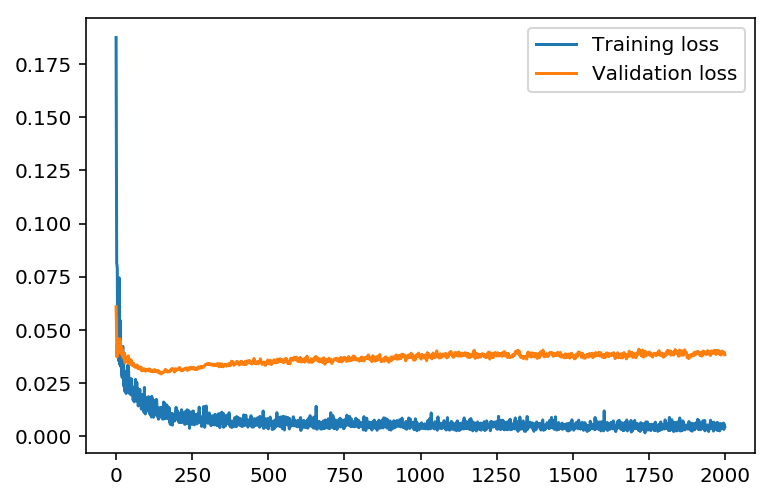

In [19]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim()

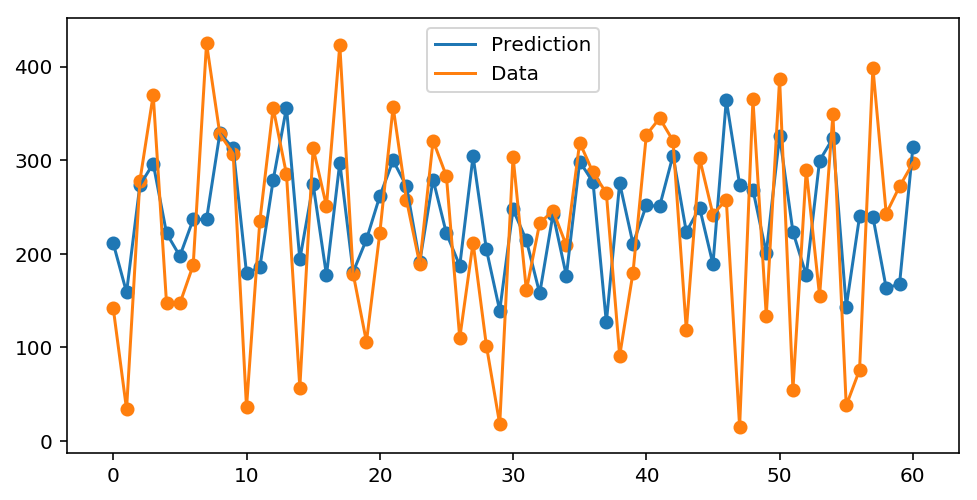

In [32]:
fig, ax = plt.subplots(figsize=(8,4))



max_, min_ = scaled_features['power_consumption']
pre = predictions*(max_ - min_) + min_
ax.plot(pre, label='Prediction')
ax.scatter(range(0, 61), pre)
val = (val_targets*(max_ - min_) + min_).values
ax.plot(val, label='Data')
ax.scatter(range(0, 61), val)
ax.legend()